In [6]:
import numpy as np
import os
import glob
from itertools import chain
import re
import pickle
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.transform import resize

In [7]:
def extract_accuracy_from_log(file_path):
    with open(file_path, 'r') as f:
        content = f.read()
        # 正規表現を使用してaccuracyを抽出
        match = re.search(r'accuracy: (\d+\.\d+)%', content)
        if match:
            return float(match.group(1))
    return None

In [8]:
dataset = ["caltech101",  "eurosat", "imagenet", "stanford_cars", "fgvc_aircraft",  "oxford_flowers", "sun397",  "dtd", "food101", "oxford_pets", "ucf101"]
filepath = "output/ZeroshotCLIP_ETran/vit_b16"

date_format = "%Y-%m-%d-%H-%M-%S"

energy_scores = {}
energy_scores_logits = {}
lda_scores = {}
lda_scores_logits = {}
accuracy_dict = {}
energy_sort_accuracies = {}
for dname in dataset:
    energy_score = np.load(os.path.join(filepath, dname, "energy_scores.npy"))
    energy_logits_score = np.load(os.path.join(filepath, dname, "energy_logits_scores.npy"))

    lda_score = np.load(os.path.join(filepath, dname, "lda_scores.npy"))
    lda_logits_score = np.load(os.path.join(filepath, dname, "lda_logits_scores.npy"))

    with open(os.path.join(filepath, dname, "energy_sort_accuracy.pkl"), "rb") as f:
        energy_sort_accuracy = pickle.load(f)
    #energy_sort_accuracy = np.load(os.path.join(filepath, dname, "energy_sort_accuracy.npy"))

    # logファイルを取得
    log_files = glob.glob(os.path.join(filepath, dname, '*log.txt*'))

    latest_date = None
    latest_file = None
    for file in log_files:
        # ファイル名から日付部分を抽出
        match = re.search(r'(\d{4}-\d{2}-\d{2}-\d{2}-\d{2}-\d{2})', file)
        if match:
            # 日付をdatetimeオブジェクトに変換
            file_date = datetime.strptime(match.group(), date_format)
            if latest_date is None or file_date > latest_date:
                latest_date = file_date
                latest_file = file
    
    # ファイル名に日付がない場合（例：log.txt）
    if latest_file is None:
        latest_file = 'log.txt'

    accuracy = extract_accuracy_from_log(latest_file)

    energy_scores[dname] = energy_score
    energy_scores_logits[dname] = energy_logits_score
    
    lda_scores[dname] = lda_score
    lda_scores_logits[dname] = lda_logits_score
    
    accuracy_dict[dname] = accuracy
    energy_sort_accuracies[dname] = energy_sort_accuracy

energy_scores_combined = np.concatenate(list(energy_scores.values()))
energy_scores_logits_combined = np.concatenate(list(energy_scores_logits.values()))

lda_scores_combined = np.array([v.tolist() for v in lda_scores.values()])
lda_scores_logits_combined = np.array([v.tolist() for v in lda_scores_logits.values()])

assert len(energy_scores_combined) == len(energy_scores_logits_combined)

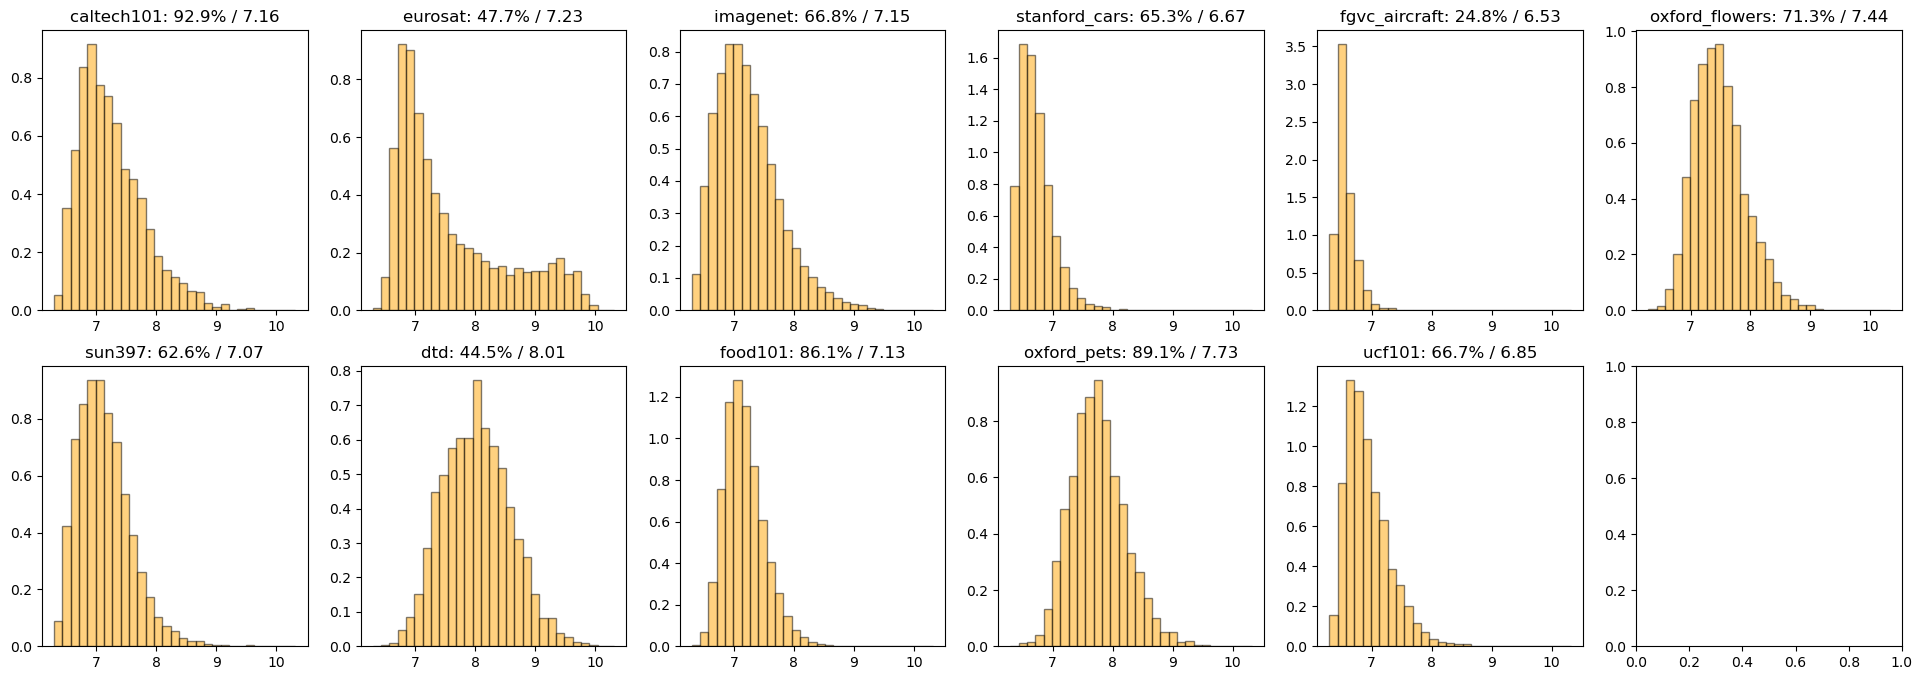

In [9]:
fig, ax = plt.subplots(2, 6, figsize=(24, 8))

n_bin = 30
x_max_1 = energy_scores_combined.max()
x_min_1 = energy_scores_combined.min()
bins_1 = np.linspace(x_min_1, x_max_1, n_bin)

x_max_2 = energy_scores_logits_combined.max()
x_min_2 = energy_scores_logits_combined.min()
bins_2 = np.linspace(x_min_2, x_max_2, n_bin)

col = 0
row = 0

accuracies = []
etran_scores = []
etran_logit_scores = []

for dname in dataset:
    ax[row][col].hist(energy_scores[dname], bins=bins_1, alpha=0.5, density=True, ec='black', color="orange")
    ax[row][col].set_title(dname + ": " + str(accuracy_dict[dname]) + "%" + " / " + str(round(np.median(energy_scores[dname]),2)))
    
    # ax[row][col].hist(energy_scores_logits[dname], bins=bins_2, alpha=0.5, density=True, ec='black', color="orange")
    # ax[row][col].set_title(dname + ": " + str(accuracy_dict[dname]) + "%" + " / " + str(round(np.median(energy_scores_logits[dname]),2)))
    
    accuracies.append(accuracy_dict[dname])
    #etran_logit_scores.append(round(np.median(energy_scores_logits[dname]),2) + lda_scores_logits[dname])
    #etran_scores.append(round(np.median(energy_scores[dname]),2) + lda_scores[dname])
    etran_logit_scores.append(round(np.median(energy_scores_logits[dname]),2))
    etran_scores.append(round(np.median(energy_scores[dname]),2))

    col += 1
    if col == 6:
        row += 1
        col = 0
    


In [ ]:
accuracies

AttributeError: 'numpy.ndarray' object has no attribute 'scatter'

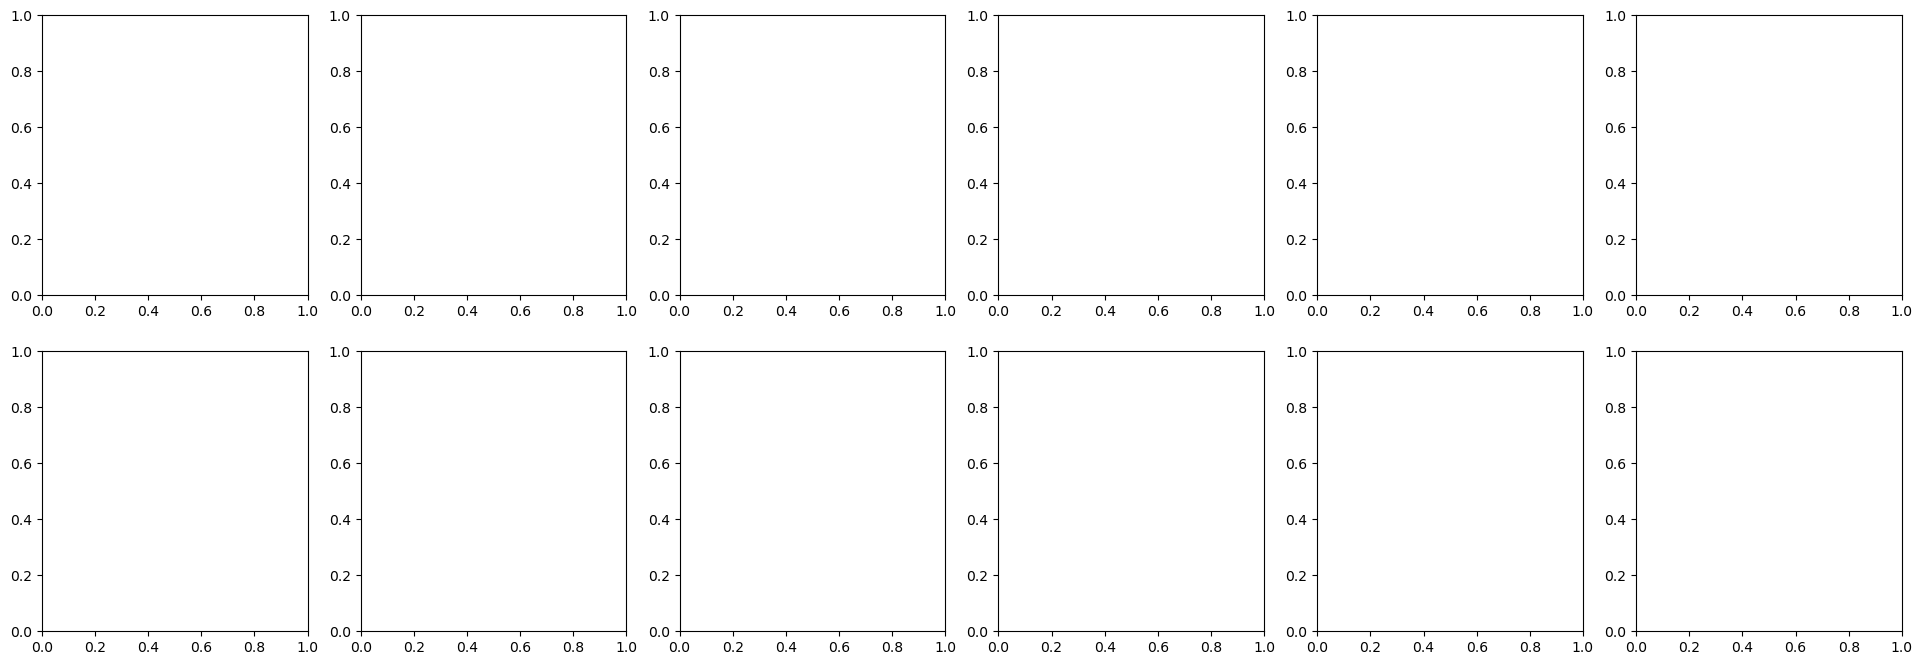

In [12]:
#fig, ax = plt.subplots(2, 6, figsize=(24, 8))
fig, ax = plt.subplots(figsize=(8, 8))

col = 0
row = 0

accuracies = []
etran_scores = []
etran_logit_scores = []

all_accuracy = []
all_energy = []
dataset = ["caltech101", "oxford_pets", "eurosat", "imagenet", "stanford_cars", "fgvc_aircraft",  "oxford_flowers", "sun397",  "dtd",  "oxford_pets", "ucf101"]
for dname in dataset:
    energy = [float(item[0]) for item in energy_sort_accuracies[dname]]
    accuracy = [float(item[1]) for item in energy_sort_accuracies[dname]]

    # accuracyを正規化？
    #accuracy = [x/max(accuracy) for x in accuracy]

    all_accuracy.append(accuracy)
    all_energy.append(energy)

    #ax[row][col].scatter(energy, accuracy, s=80, alpha=0.8, color="orange")
    #ax[row][col].set_title(dname + ": " + str(accuracy_dict[dname]) + "%")
    
    col += 1
    if col == 6:
        row += 1
        col = 0
    
all_energy = list(chain.from_iterable(all_energy))
all_accuracy = list(chain.from_iterable(all_accuracy))
all_accuracy = [x/max(all_accuracy) for x in all_accuracy]

ax.scatter(all_energy, all_accuracy, s=80, alpha=0.8, color="orange")

Mean energy of correct samples is 7.100629948851639
Mean energy of mistake samples is 6.980823025382691


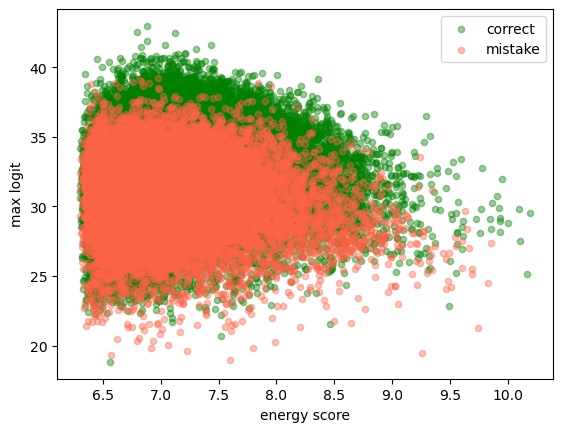

In [108]:
import seaborn as sns

dataset = ["ucf101", "food101", "oxford_pets", "oxford_flowers", "dtd", "fgvc_aircraft", "stanford_cars", "sun397", "caltech101"]
#dataset = ["oxford_flowers"]
filepath = "output/ZeroshotCLIP_ETran/vit_b16"

date_format = "%Y-%m-%d-%H-%M-%S"

energy_scores = []
all_logits = []
accuracy_color = []
energy_sort_accuracies = {}
for dname in dataset:
    energy_score = np.load(os.path.join(filepath, dname, "energy_scores.npy"))
    logits = np.load(os.path.join(filepath, dname, "logits.npy"))
    labels = np.load(os.path.join(filepath, dname, "labels.npy"))

    logits_max = np.max(logits, axis=1)

    pred = np.argmax(logits, axis=1)
    accuracy = pred == labels
    accuracy_color.extend(accuracy)

    energy_scores.extend(energy_score)
    all_logits.extend(logits_max)


energy_scores = np.array(energy_scores)
all_logits = np.array(all_logits)
accuracy_color = np.array(accuracy_color)


fig, ax = plt.subplots()

#sns.histplot(x=energy_scores, y=all_logits, cmap="Oranges")
cmap = plt.get_cmap("tab10")

plt.xlabel("energy score")
plt.ylabel("max logit")
plt.scatter(energy_scores[accuracy_color==True], all_logits[accuracy_color==True], s=20, alpha=0.4, c="green", label="correct")
plt.scatter(energy_scores[accuracy_color==False], all_logits[accuracy_color==False], s=20, alpha=0.4, c="tomato", label="mistake")
plt.legend()

print(f"Mean energy of correct samples is {np.median(energy_scores[accuracy_color==True])}")
print(f"Mean energy of mistake samples is {np.median(energy_scores[accuracy_color==False])}")

In [77]:
energy_scores

[7.287432162995898,
 7.038515758676025,
 6.994334649145047,
 7.065523766722836,
 6.9456654246181175,
 7.451134382278617,
 6.530190092183888,
 6.554796376913493,
 6.719135837224893,
 6.927949471164738,
 7.219819886671752,
 6.506083319846435,
 7.0870381005122995,
 6.855552904917018,
 7.0264667359791835,
 6.779710368941778,
 6.627506744260382,
 6.6349226985333845,
 6.584981598822759,
 6.6864318473020985,
 6.5693536080305375,
 6.6842714968494725,
 6.888561175948432,
 7.048711056172264,
 7.524099251528226,
 7.119252920562157,
 7.0190916630601015,
 7.52959323202112,
 6.749090891826809,
 7.182639541135353,
 6.969438649686573,
 6.647960026810149,
 7.039426864031123,
 6.86811309299657,
 6.811687365114349,
 6.776571872857128,
 7.075627835037008,
 6.590517413523928,
 6.6013897259732515,
 6.577155965334012,
 6.571310949246988,
 6.609816114062202,
 6.664370636237987,
 6.663631300901321,
 6.945385247334266,
 7.2031757800386975,
 6.921512105696227,
 6.812242778600121,
 6.711694957867559,
 6.511957866

In [ ]:
fig, ax = plt.subplots(2, 10, figsize=(24, 4))
ax = ax.ravel()
target_size = (256, 256)
resize_size = (128, 128)

for i, (energy, accuracy, paths) in enumerate(energy_sort_accuracies['sun397']):
    energy = round(float(energy), 2)
    accuracy = round(float(accuracy), 2)

    segments = []
    for path in paths:
        img = mpimg.imread(path)
        img_resized = resize(img, resize_size, anti_aliasing=True)
        if img_resized.ndim == 2:  # グレースケール画像の場合
            img_resized = np.stack((img_resized,) * 3, axis=-1)  # カラーチャンネルを追加
        segments.append(img_resized)

    # 画像を4分割して表示する
    combined_image = np.zeros((target_size[0], target_size[1], 3))
    mid_row, mid_col = target_size[0] // 2, target_size[1] // 2

    combined_image[:mid_row, :mid_col] = segments[0][:mid_row, :mid_col]  # 左上
    combined_image[:mid_row, mid_col:] = segments[1][:mid_row, :mid_col]  # 右上
    combined_image[mid_row:, :mid_col] = segments[2][:mid_row, :mid_col]  # 左下
    combined_image[mid_row:, mid_col:] = segments[3][:mid_row, :mid_col]  # 右下

    #img = mpimg.imread(path)
    ax[i].imshow(combined_image)
    ax[i].text(0.89, 0.89, energy, color='black', fontsize=8, ha='center', va='center', transform=ax[i].transAxes, backgroundcolor="white")
    ax[i].axis('off')
    ax[i].set_title(f"mean accurcy: {accuracy}")



In [ ]:
a=[]
a.append(tuple([1,2,tuple([1,2])]))
a.append(tuple([1,2,tuple([1,2])]))
a